# Imports

In [2]:
from os import listdir,mkdir,makedirs
from os.path import isfile, join, isdir,exists
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from myplots import roundup, rounddown, find_decimal_fold, percentile_cut_off, rarefaction_calc, rarefaction_plot,draw_correlation_scatter
from matplotlib.ticker import FormatStrFormatter
import cPickle as pickle
from Bio.SeqUtils import GC
import seaborn as sns
import random
from scipy.stats import pearsonr,fisher_exact
from skbio.diversity.alpha import shannon, simpson, berger_parker_d

from pop_organize import get_sample_data, get_sample_with_dfs
from SufficientStatistics import *
from MyFunctionsShani import *
import math
from myplots import roundup, rounddown, find_decimal_fold
from skbio.stats.distance import mantel
from scipy.spatial.distance import braycurtis, pdist, euclidean


from GeneralFeaturePhenotypeInteractions.Feature_phenotype_functions import * 
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions import *
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions2 import *
from SampleLists.SampleFileFunctions import *
from PhenotypicData.PhenotypeGenerationFunctions import *
from CardioProject.CardioFunctions import *
from PredictionPipeline.PredictionFunctions import *
from TCR_feature_generation.SubsamplingFunctions import *

import os
from Utils import cacheOnDisk
from queue.qp import qp,fakeqp
from addloglevels import sethandlers

#ML imports:
from xgboost import XGBClassifier
import lightgbm as lgb
from collections import OrderedDict
from sklearn.model_selection import GroupKFold,StratifiedKFold, KFold
import statsmodels.formula.api as sm
from sklearn.linear_model import LogisticRegression
import shap
from sklearn import metrics, preprocessing
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel,SelectKBest,chi2,mutual_info_classif,f_classif
from sklearn.naive_bayes import GaussianNB

MyPath='/net/mraid08/export/genie/Lab/Personal/ShaniBAF'

done1
stop
stop
done1
stop
done
done
done
done
stop
stop
end of function!!!


/usr/wisdom/python/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


end of function!!!


In [3]:
import time
cdate=str(time.strftime("%d%m%Y"))
cdate


'16092018'

# plan

1. go over PNP phenotypes and check for outliers and mistakes.
2. explore features and see if needs to correct
3. check categorial features - were they all one-hot encoded
4. write function for parameter tuning for light GBM
5. write function for parameter tuning for XGBoost
6. write function for parameter tuning for logistic regression?
7. write new prediction function for each model 
   a. cv set up

# correction of phenotype file


new phenotype file was generatged for the cardio126 cohort based on the most updated 'medical database' sent by Yeela in August 2018.
in addition, the phenotype file for the PNP cohort was generated again too. *** the phenotypes are now not filtered for outliers*** in order to enable fair comparison vs. the cardio phenotype file. in addition, some phenotypes were added (glucose, cholesterol etc. )
phenotype file generateion was done using 'New PNP phenotype file' notebook. phenotypes are extracted using the 'PhenotypicDataGenerationNewVersion' notebook.

# exploration of the TCR feature file:

In [ ]:
featureFilePickle2='%s/TCR_real_data/PNP530Cardio126Combined/featureSummaryDFs/PNP530Cardio126_filteredByPNP530Cardio126_allFeatures_\
noCorrelated' %MyPath
PNP530Cardio126TCRfeatureDF_noCorr=pd.read_pickle(featureFilePickle2)

## explore feature file:

In [ ]:
the function explore_feature_table was copied to TCR_feature_generation.py

In [ ]:
featureDF=PNP530Cardio126TCRfeatureDF_noCorr
df=explore_feature_table(featureDF)

f3='%s/TCR_real_data/PNP530Cardio126Combined/featureSummaryDFs/PNP530Cardio126_filteredByPNP530Cardio126_allFeatures_\
noCorrelated_ANALYSIS.xlsx' %MyPath
df.to_excel(f3)

## delete all constant features

In [ ]:
# remove constant columns - there are no such columns now
constantdf=df[df['Type']=='constant']
constantVars=constantdf['columns'].tolist()
print constantVars
print PNP530Cardio126TCRfeatureDF_noCorr.shape
PNP530Cardio126TCRfeatureDF_noCorr=PNP530Cardio126TCRfeatureDF_noCorr.drop(constantVars,axis=1)
print PNP530Cardio126TCRfeatureDF_noCorr.shape

## fillna with 0's for all gene usage features

In [ ]:
colsTofill=[x for x in PNP530Cardio126TCRfeatureDF_noCorr.columns.values if 'norm' not in x]
print len(colsTofill)
print len(PNP530Cardio126TCRfeatureDF_noCorr.columns)

PNP530Cardio126TCRfeatureDF_noCorr[colsTofill]=PNP530Cardio126TCRfeatureDF_noCorr[colsTofill].fillna(0)

In [ ]:
f3='%s/TCR_real_data/PNP530Cardio126Combined/featureSummaryDFs/PNP530Cardio126_filteredByPNP530Cardio126_allFeatures_\
noCorrelated_noConsts_filledna.xlsx' %MyPath

PNP530Cardio126TCRfeatureDF_noCorr.to_excel(f3)

f4='%s/TCR_real_data/PNP530Cardio126Combined/featureSummaryDFs/PNP530Cardio126_filteredByPNP530Cardio126_allFeatures_\
noCorrelated_noConsts_filledna' %MyPath

PNP530Cardio126TCRfeatureDF_noCorr.to_pickle(f4)

# using old prediction functions with new features and phenotypes:

## comparing only phenotypes with different feature combinations:
1. use 10,50,100,200, all features
2. use all 3 models
3. change phenotype list and use new phenotype file
4. use new feature file
5. use the following feature combinations: sequences only, VDJ combinations only, add total tcr features and PCA, add total tcr features and PCA with only 10 comps

In [5]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
    Cardio126=pickle.load(fp)
sampleList=PNP530+Cardio126
sampleListName='PNP530Cardio126'
percShared=10

# phenotype df:
PNPphenotypeFile='%s/TCR_real_data/NewPhenotypicData/newPhenotypesPNPAllInfo_withDummies.xlsx' %MyPath
PNPphenotypeDF=pd.read_excel(PNPphenotypeFile).set_index('BD')
PNP530phenotypeDF=PNPphenotypeDF.loc[PNP530,:]

CardiophenotypeFile='%s/TCR_real_data/CardioSamples/phenotypicData/Cardio126phenAllInfo_withDummies.xlsx' %MyPath
CardiophenotypeDF=pd.read_excel(CardiophenotypeFile).set_index('BD')

PNP530Cardio126PhenotypeFile='%s/TCR_real_data/PNP530Cardio126Combined/Phenotypes/PNP530Cardio126_phen_new_withDummies.xlsx' %MyPath
combinedPhenotypeDF=pd.concat([PNP530phenotypeDF,CardiophenotypeDF])
# combinedPhenotypeDF=combinedPhenotypeDF.set_index('BD')
print len(combinedPhenotypeDF)
print combinedPhenotypeDF.iloc[:4,:4]
combinedPhenotypeDF.to_excel(PNP530Cardio126PhenotypeFile)

#TCRdf:
print 'getting TCRdf...'

sharingFolder='%s/TCR_real_data/PNP530Cardio126Combined/sharingAnalysis' %MyPath
TCRdfName='sharingMatrix_PNP530Cardio126_minNshared5_RA_onlyProductiveTrue__percShared%s_OLtrimmed_binary' %percShared
TCRdfFile='%s/%s' %(sharingFolder,TCRdfName )
print TCRdfFile
TCRdf=pd.read_pickle(TCRdfFile)
print 'TCRdf shape is %s_%s' %(TCRdf.shape[0],TCRdf.shape[1])
print TCRdf.iloc[:4,:4]

#Features
print 'getting TCRfeatureDF - without highly correlated columns...'
featureFilePickle2='%s/TCR_real_data/PNP530Cardio126Combined/featureSummaryDFs/PNP530Cardio126_filteredByPNP530Cardio126\
_allFeatures_noCorrelated_noConsts_filledna' %MyPath
TCRfeatureDF2=pd.read_pickle(featureFilePickle2)
print 'TCRfeatureDF shape is %s_%s' %(TCRfeatureDF2.shape[0],TCRfeatureDF2.shape[1])
TCRfeatureDF2.iloc[:4,:4]


/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



656
         AST Admission Diagnosis  Admission Diagnosis_NSTEMI  \
BD                                                             
BD406  17.00                 NaN                         NaN   
BD228  30.00                 NaN                         NaN   
BD714  18.75                 NaN                         NaN   
BD808  16.00                 NaN                         NaN   

       Admission Diagnosis_STEMI  
BD                                
BD406                        NaN  
BD228                        NaN  
BD714                        NaN  
BD808                        NaN  
getting TCRdf...
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/PNP530Cardio126Combined/sharingAnalysis/sharingMatrix_PNP530Cardio126_minNshared5_RA_onlyProductiveTrue__percShared10_OLtrimmed_binary
TCRdf shape is 656_1199
        CASRGETQYF  CASRGGETQYF  CASRGNTEAFF  CASRGQGNTEAFF
Sample                                                     
BD1            0.0          0.0          0.

,AA count_0,AA count_1,AA count_T,D01_0
BD406,190.0,8017.0,8207.0,0.381305
BD228,357.0,12365.0,12722.0,0.383422
BD714,208.0,10560.0,10768.0,0.459386
BD808,359.0,19513.0,19872.0,0.508576


******featureComposition=phenotypesOnly, k=10,modelAndParams=(<class 'sklearn.linear_model.logistic.LogisticRegression'>, 'LogisticRegression', {'penalty': 'l1', 'C': 10}),featureSelectionMethod=None,n_comp=10********
target value counts:
0    949
1    150
Name: isCardio, dtype: int64
y shape is 1099
y head:
BD1    0
BD2    0
BD3    0
BD4    0
BD5    0
Name: isCardio, dtype: int64
BD1095    1
BD1096    1
BD1097    1
BD1098    1
BD1099    1
Name: isCardio, dtype: int64
fillnas with column medians in phenotypeDF..


/home/sbenari/workspace/Microbiome/ShaniBA/PredictionPipeline/PredictionFunctions.py:484: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  phenotypeDF[col]=phenotypeDF[col].fillna(phenotypeDF[col].median())


final phenotype shape is 656_13
phenotypeDF head:
       Smoking Status_Past  Smoking Status_Yes  Gender_Male   Age        BMI  \
BD406                    0                   0            0  65.0  27.181630   
BD228                    0                   0            1  32.0  28.727377   
BD714                    0                   0            1  39.0  27.216277   
BD808                    0                   0            0  26.0  18.423259   
BD144                    1                   0            0  36.0  24.386526   

       eGFR by CKD-EPI  HbA1C  Glucose    AST  Hemoglobin   WBC   HDL  \
BD406             54.0   6.40    96.00  17.00      13.100  6.20  93.0   
BD228             90.0   5.10   103.00  30.00      14.600  9.00  34.8   
BD714             93.0   5.31   102.75  18.75      16.025  8.05  44.4   
BD808             87.0   5.18    79.00  16.00      12.800  6.00  64.9   
BD144             83.0   5.10    99.00  18.00      13.900  7.20  89.5   

       Total Cholesterol  
BD4

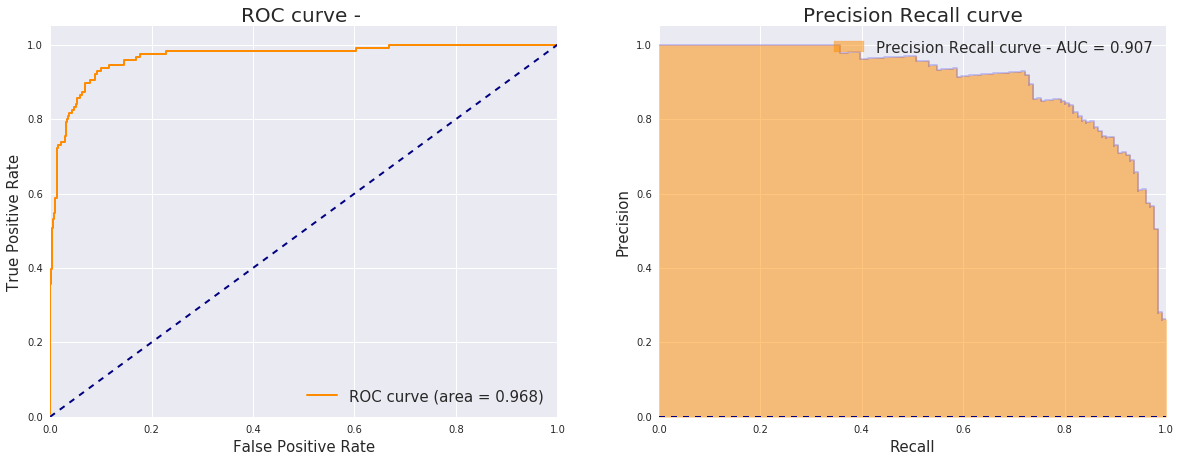

generating summarizing df
126 530
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/Predictions130918/isCardio_predictions/LogisticRegression/predictionDFs/PNP530Cardio126_phenotypesOnly_scaled_C10_penaltyl1_CV10.xlsx
      Yname                                  Xname           modelName  \
0  isCardio  PNP530Cardio126_phenotypesOnly_scaled  LogisticRegression   

   roc_auc  pr_auc  perc_pos_target  pr_auc_corrected  useCV  \
0    0.968   0.907            0.192             0.715   True   

   featureSelectionMethod features used  total num features used  \
0                     NaN                                    0.0   

   Num features used per split  n_splits     C penalty   nPos   nNeg     cdate  
0                         13.0      10.0  10.0      l1  126.0  530.0  16092018  
done!!
******featureComposition=phenotypesOnly, k=10,modelAndParams=(<class 'sklearn.linear_model.logistic.LogisticRegression'>, 'LogisticRegression', {'penalty': 'l1', 'C': 10}),

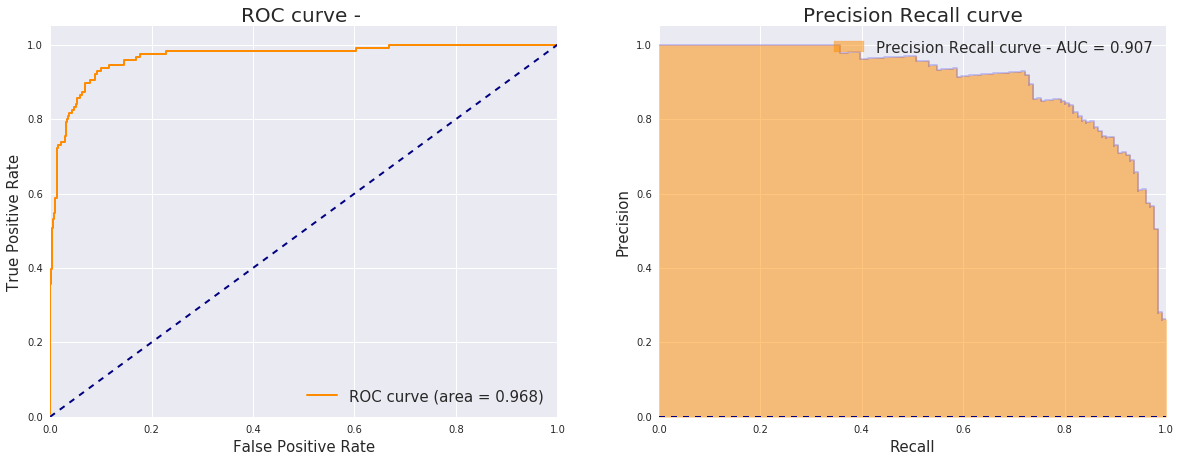

generating summarizing df
126 530
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/Predictions130918/isCardio_predictions/LogisticRegression/predictionDFs/PNP530Cardio126_phenotypesOnly_scaled_C10_penaltyl1_CV10.xlsx
      Yname                                  Xname           modelName  \
0  isCardio  PNP530Cardio126_phenotypesOnly_scaled  LogisticRegression   

   roc_auc  pr_auc  perc_pos_target  pr_auc_corrected  useCV  \
0    0.968   0.907            0.192             0.715   True   

   featureSelectionMethod features used  total num features used  \
0                     NaN                                    0.0   

   Num features used per split  n_splits     C penalty   nPos   nNeg     cdate  
0                         13.0      10.0  10.0      l1  126.0  530.0  16092018  
done!!
******featureComposition=phenotypesOnly, k=10,modelAndParams=(<class 'lightgbm.sklearn.LGBMClassifier'>, 'LGBMClassifier', {'num_threads': 2, 'bagging_seed': 3, 'bagging_fr

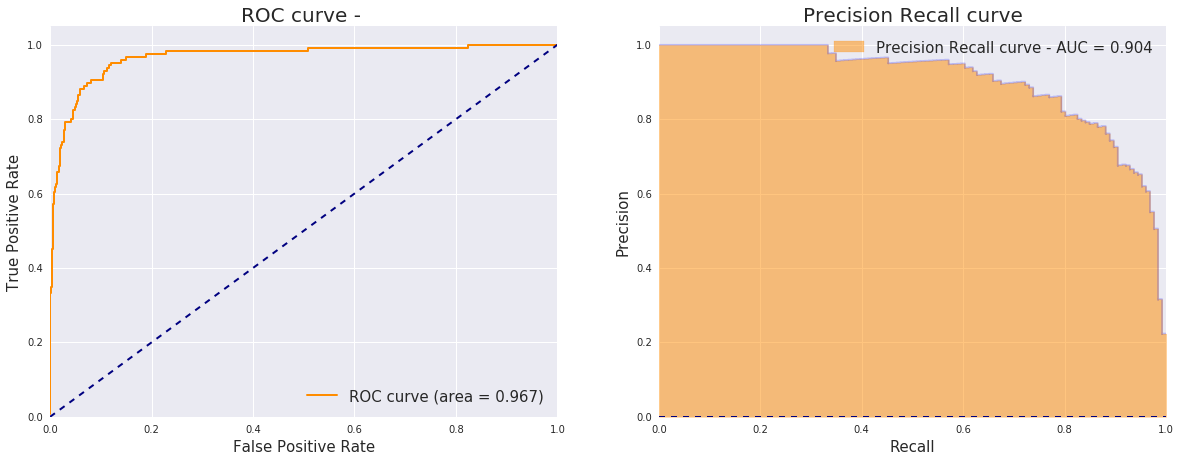

generating summarizing df
126 530
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/Predictions130918/isCardio_predictions/LGBMClassifier/predictionDFs/PNP530Cardio126_phenotypesOnly_scaled_baggingfraction0-5_baggingfreq1_baggingseed3_learningrate0-05_maxdepth6_nestimators100_numthreads2_CV10.xlsx
      Yname                                  Xname       modelName  roc_auc  \
0  isCardio  PNP530Cardio126_phenotypesOnly_scaled  LGBMClassifier    0.967   

   pr_auc  perc_pos_target  pr_auc_corrected  useCV  featureSelectionMethod  \
0   0.904            0.192             0.712   True                     NaN   

  features used    ...     bagging_fraction  bagging_freq  bagging_seed  \
0                  ...                  0.5           1.0           3.0   

   learning_rate  max_depth  n_estimators  num_threads   nPos   nNeg     cdate  
0           0.05        6.0         100.0          2.0  126.0  530.0  16092018  

[1 rows x 23 columns]
done!!
******featureC

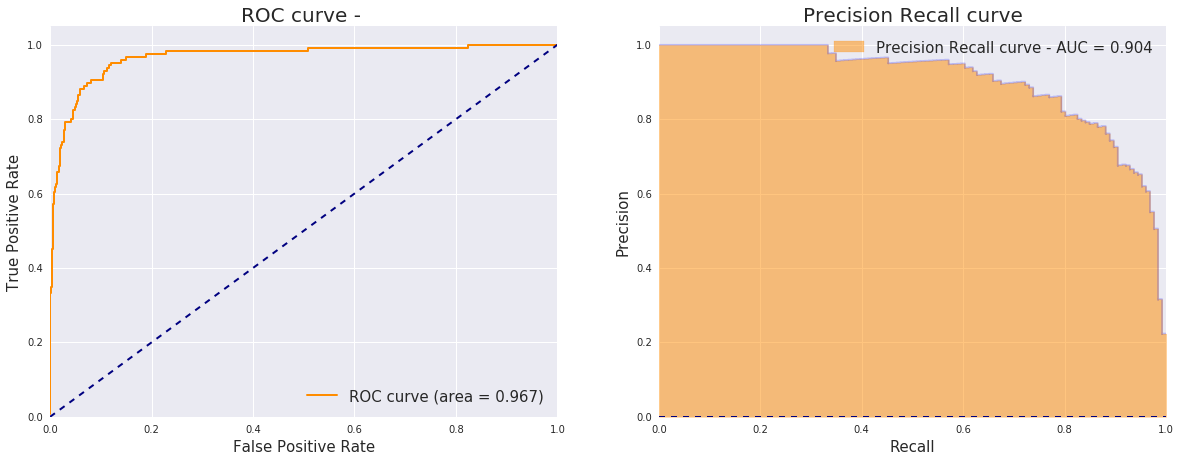

generating summarizing df
126 530
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/Predictions130918/isCardio_predictions/LGBMClassifier/predictionDFs/PNP530Cardio126_phenotypesOnly_scaled_baggingfraction0-5_baggingfreq1_baggingseed3_learningrate0-05_maxdepth6_nestimators100_numthreads2_CV10.xlsx
      Yname                                  Xname       modelName  roc_auc  \
0  isCardio  PNP530Cardio126_phenotypesOnly_scaled  LGBMClassifier    0.967   

   pr_auc  perc_pos_target  pr_auc_corrected  useCV  featureSelectionMethod  \
0   0.904            0.192             0.712   True                     NaN   

  features used    ...     bagging_fraction  bagging_freq  bagging_seed  \
0                  ...                  0.5           1.0           3.0   

   learning_rate  max_depth  n_estimators  num_threads   nPos   nNeg     cdate  
0           0.05        6.0         100.0          2.0  126.0  530.0  16092018  

[1 rows x 23 columns]
done!!
******featureC

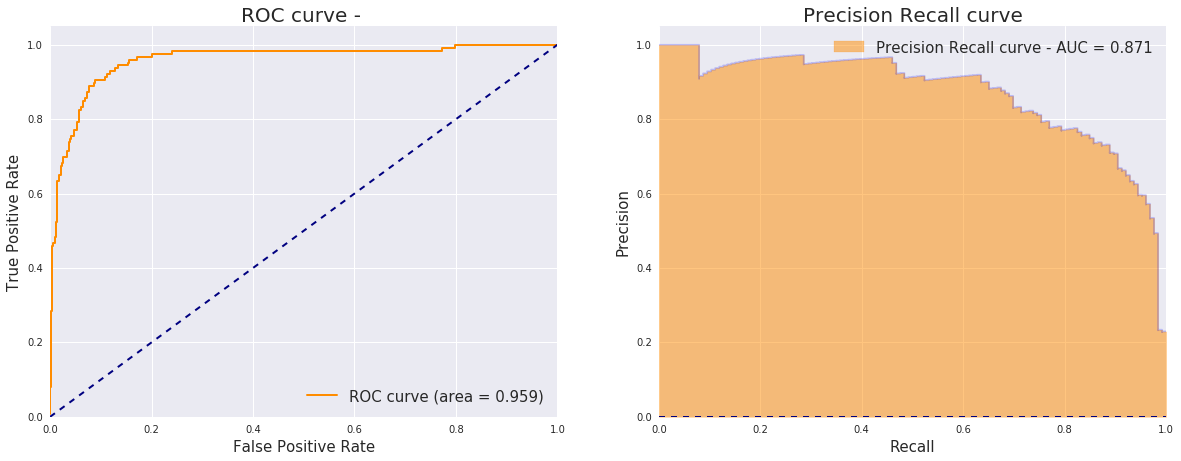

generating summarizing df
126 530
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/Predictions130918/isCardio_predictions/XGBClassifier/predictionDFs/PNP530Cardio126_phenotypesOnly_scaled_baggingfraction0-5_baggingfreq1_baggingseed3_learningrate0-05_maxdepth6_nestimators100_numthreads2_CV10.xlsx
      Yname                                  Xname      modelName  roc_auc  \
0  isCardio  PNP530Cardio126_phenotypesOnly_scaled  XGBClassifier    0.959   

   pr_auc  perc_pos_target  pr_auc_corrected  useCV  featureSelectionMethod  \
0   0.871            0.192             0.679   True                     NaN   

  features used    ...     bagging_fraction  bagging_freq  bagging_seed  \
0                  ...                  0.5           1.0           3.0   

   learning_rate  max_depth  n_estimators  num_threads   nPos   nNeg     cdate  
0           0.05        6.0         100.0          2.0  126.0  530.0  16092018  

[1 rows x 23 columns]
done!!
******featureComp

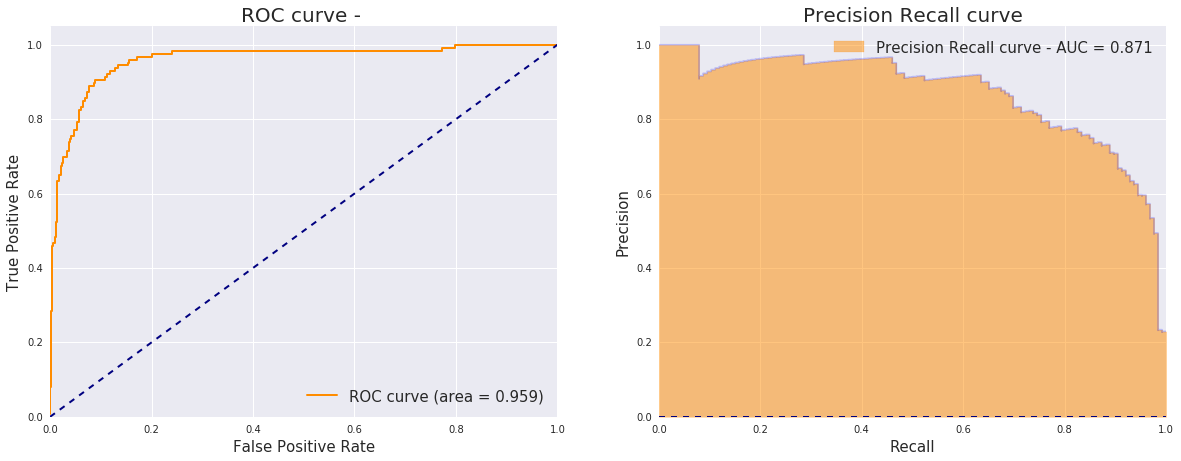

generating summarizing df
126 530
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/Predictions130918/isCardio_predictions/XGBClassifier/predictionDFs/PNP530Cardio126_phenotypesOnly_scaled_baggingfraction0-5_baggingfreq1_baggingseed3_learningrate0-05_maxdepth6_nestimators100_numthreads2_CV10.xlsx
      Yname                                  Xname      modelName  roc_auc  \
0  isCardio  PNP530Cardio126_phenotypesOnly_scaled  XGBClassifier    0.959   

   pr_auc  perc_pos_target  pr_auc_corrected  useCV  featureSelectionMethod  \
0   0.871            0.192             0.679   True                     NaN   

  features used    ...     bagging_fraction  bagging_freq  bagging_seed  \
0                  ...                  0.5           1.0           3.0   

   learning_rate  max_depth  n_estimators  num_threads   nPos   nNeg     cdate  
0           0.05        6.0         100.0          2.0  126.0  530.0  16092018  

[1 rows x 23 columns]
done!!
******featureComp

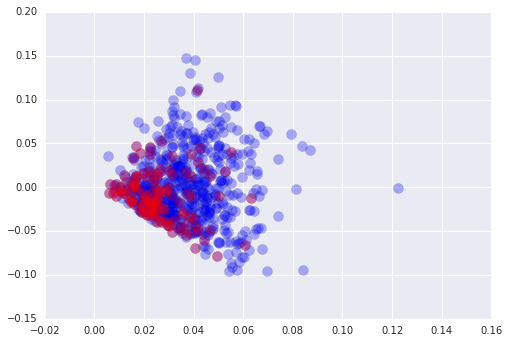

PCAdf shape is 656_10
TCRfeatureDF shape is 656_613
TCRfeatureDF head:
       AA count_0  AA count_1  AA count_T     D01_0
BD406       190.0      8017.0      8207.0  0.381305
BD228       357.0     12365.0     12722.0  0.383422
BD714       208.0     10560.0     10768.0  0.459386
BD808       359.0     19513.0     19872.0  0.508576
number of columns that include nans and their name doesnt include -norm- is 0
these columns will be fillna-ed with 0s
now the number of columns with nan values is 4
building X from its components:
number of Xcomponents to be used is 3
combined X shape is 656_636
656
since logRef model or univaraite feature selection is used, needs to fillnas in phenotype columns...
X shape after dropping nan columns is 656_632
Xshape after dropping rows with nans=656_632
filtering X rows with sample List = Cardio126
Xshape after filtering rows with sample list = 656_632:
X shape is 656_632
the 100th sample in X is BD124
        Smoking Status_Past  Smoking Status_Yes  Gender_Ma

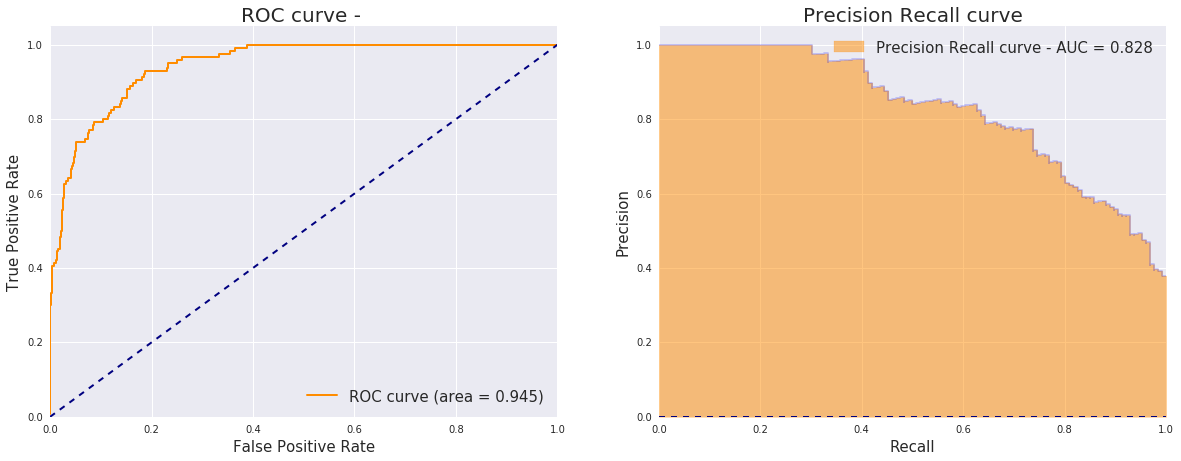

generating summarizing df
126 530
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/Predictions130918/isCardio_predictions/LogisticRegression/predictionDFs/PNP530Cardio126_phenotypes&PCA&TCRfeatures_FSMNone10_scaled_C10_penaltyl1_CV10.xlsx
      Yname                                              Xname  \
0  isCardio  PNP530Cardio126_phenotypes&PCA&TCRfeatures_FSM...   

            modelName  roc_auc  pr_auc  perc_pos_target  pr_auc_corrected  \
0  LogisticRegression    0.945   0.828            0.192             0.636   

   useCV  featureSelectionMethod features used  total num features used  \
0   True                     NaN                                    0.0   

   Num features used per split  n_splits     C penalty   nPos   nNeg     cdate  
0                        632.0      10.0  10.0      l1  126.0  530.0  16092018  
done!!
******featureComposition=phenotypes&PCA&TCRfeatures, k=10,modelAndParams=(<class 'sklearn.linear_model.logistic.LogisticRegres

             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
BD1     0.058212 -0.063789 -0.066825  0.125777 -0.076944  0.074758  0.036027   
BD10    0.061757  0.042230 -0.089386 -0.072909 -0.084923  0.004008 -0.014780   
BD1000  0.026693  0.052183  0.027373  0.012638  0.042272 -0.018292  0.009655   
BD1001  0.025615 -0.020438 -0.019540  0.015711  0.002077 -0.000677  0.016378   
BD1002  0.008733  0.004283  0.015124  0.014993 -0.012530  0.000818 -0.002270   

             PC8       PC9      PC10    ...         PC93      PC94      PC95  \
BD1    -0.017756 -0.018324 -0.000549    ...    -0.018748  0.033659  0.059363   
BD10    0.003969 -0.013673  0.030219    ...     0.041279  0.035948  0.015279   
BD1000  0.016931  0.001586  0.024700    ...    -0.042100  0.006226  0.000668   
BD1001  0.010581 -0.002832  0.038932    ...    -0.003868  0.025706  0.044047   
BD1002 -0.013538  0.005867  0.001091    ...    -0.025730  0.006663  0.002700   

            PC96      PC97      PC98  

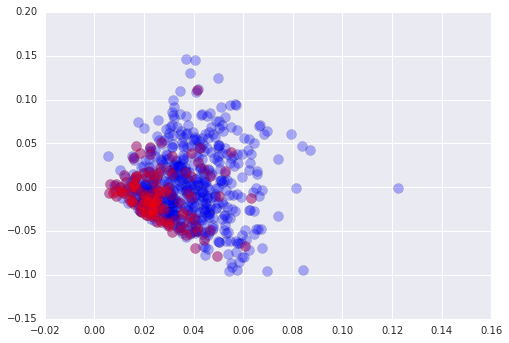

PCAdf shape is 656_100
TCRfeatureDF shape is 656_613
TCRfeatureDF head:
       AA count_0  AA count_1  AA count_T     D01_0
BD406       190.0      8017.0      8207.0  0.381305
BD228       357.0     12365.0     12722.0  0.383422
BD714       208.0     10560.0     10768.0  0.459386
BD808       359.0     19513.0     19872.0  0.508576
number of columns that include nans and their name doesnt include -norm- is 0
these columns will be fillna-ed with 0s
now the number of columns with nan values is 4
building X from its components:
number of Xcomponents to be used is 3
combined X shape is 656_726
656
since logRef model or univaraite feature selection is used, needs to fillnas in phenotype columns...
X shape after dropping nan columns is 656_722
Xshape after dropping rows with nans=656_722
filtering X rows with sample List = Cardio126
Xshape after filtering rows with sample list = 656_722:
X shape is 656_722
the 100th sample in X is BD124
        Smoking Status_Past  Smoking Status_Yes  Gender_M

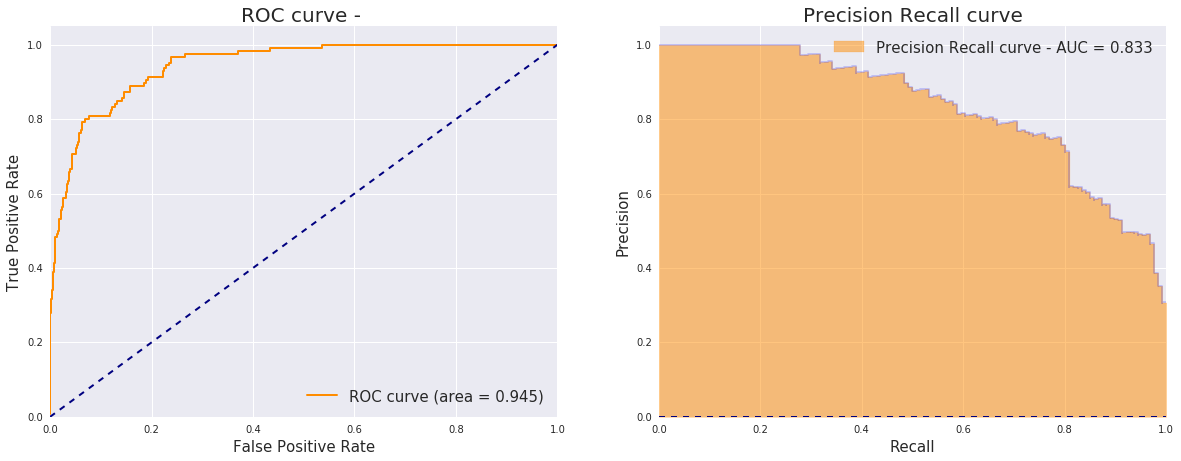

generating summarizing df
126 530
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/Predictions130918/isCardio_predictions/LogisticRegression/predictionDFs/PNP530Cardio126_phenotypes&PCA&TCRfeatures_FSMNone10_scaled_C10_penaltyl1_CV10.xlsx
      Yname                                              Xname  \
0  isCardio  PNP530Cardio126_phenotypes&PCA&TCRfeatures_FSM...   

            modelName  roc_auc  pr_auc  perc_pos_target  pr_auc_corrected  \
0  LogisticRegression    0.945   0.833            0.192             0.641   

   useCV  featureSelectionMethod features used  total num features used  \
0   True                     NaN                                    0.0   

   Num features used per split  n_splits     C penalty   nPos   nNeg     cdate  
0                        722.0      10.0  10.0      l1  126.0  530.0  16092018  
done!!
******featureComposition=phenotypes&PCA&TCRfeatures, k=10,modelAndParams=(<class 'lightgbm.sklearn.LGBMClassifier'>, 'LGBMClas

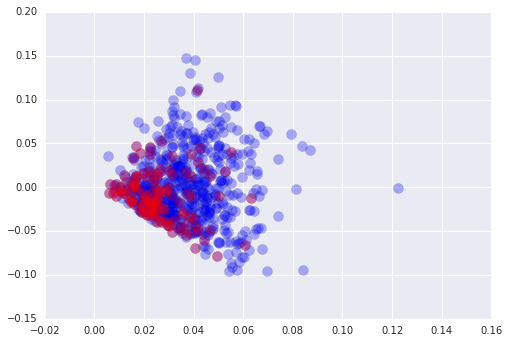

PCAdf shape is 656_10
TCRfeatureDF shape is 656_613
TCRfeatureDF head:
       AA count_0  AA count_1  AA count_T     D01_0
BD406       190.0      8017.0      8207.0  0.381305
BD228       357.0     12365.0     12722.0  0.383422
BD714       208.0     10560.0     10768.0  0.459386
BD808       359.0     19513.0     19872.0  0.508576
number of columns that include nans and their name doesnt include -norm- is 0
these columns will be fillna-ed with 0s
now the number of columns with nan values is 4
building X from its components:
number of Xcomponents to be used is 3
combined X shape is 656_636
656
filtering X rows with sample List = Cardio126
Xshape after filtering rows with sample list = 656_636:
X shape is 656_636
the 100th sample in X is BD124
        Smoking Status_Past  Smoking Status_Yes  Gender_Male
BD1                       1                   0            0
BD10                      1                   0            1
BD1000                    0                   1            1
Y shap

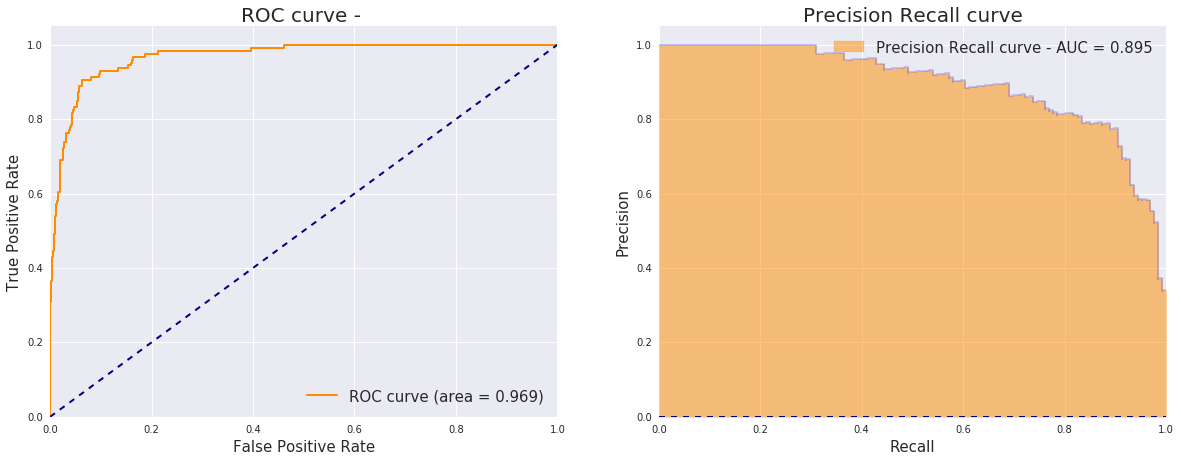

generating summarizing df
126 530
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/Predictions130918/isCardio_predictions/LGBMClassifier/predictionDFs/PNP530Cardio126_phenotypes&PCA&TCRfeatures_FSMNone10_scaled_baggingfraction0-5_baggingfreq1_baggingseed3_learningrate0-05_maxdepth6_nestimators100_numthreads2_CV10.xlsx
      Yname                                              Xname  \
0  isCardio  PNP530Cardio126_phenotypes&PCA&TCRfeatures_FSM...   

        modelName  roc_auc  pr_auc  perc_pos_target  pr_auc_corrected  useCV  \
0  LGBMClassifier    0.969   0.895            0.192             0.703   True   

   featureSelectionMethod features used    ...     bagging_fraction  \
0                     NaN                  ...                  0.5   

   bagging_freq  bagging_seed  learning_rate  max_depth  n_estimators  \
0           1.0           3.0           0.05        6.0         100.0   

   num_threads   nPos   nNeg     cdate  
0          2.0  126.0  530.0

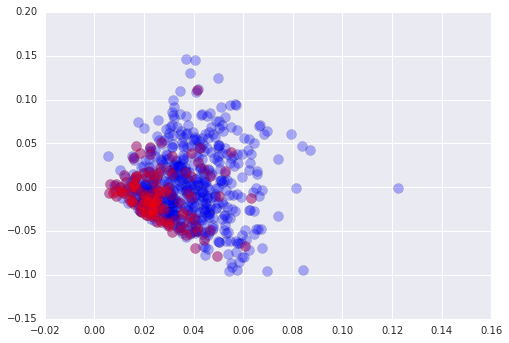

PCAdf shape is 656_100
TCRfeatureDF shape is 656_613
TCRfeatureDF head:
       AA count_0  AA count_1  AA count_T     D01_0
BD406       190.0      8017.0      8207.0  0.381305
BD228       357.0     12365.0     12722.0  0.383422
BD714       208.0     10560.0     10768.0  0.459386
BD808       359.0     19513.0     19872.0  0.508576
number of columns that include nans and their name doesnt include -norm- is 0
these columns will be fillna-ed with 0s
now the number of columns with nan values is 4
building X from its components:
number of Xcomponents to be used is 3
combined X shape is 656_726
656
filtering X rows with sample List = Cardio126
Xshape after filtering rows with sample list = 656_726:
X shape is 656_726
the 100th sample in X is BD124
        Smoking Status_Past  Smoking Status_Yes  Gender_Male
BD1                       1                   0            0
BD10                      1                   0            1
BD1000                    0                   1            1
Y sha

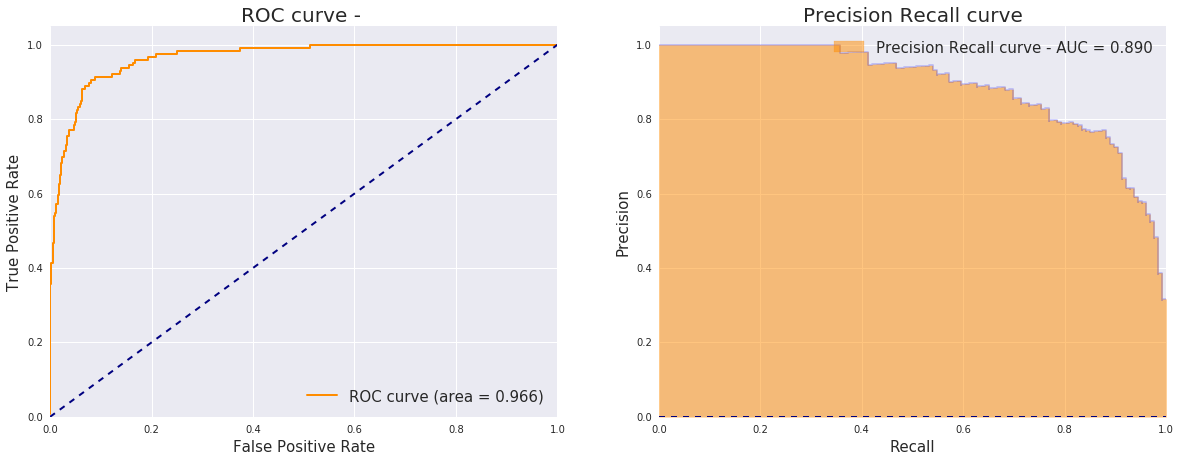

generating summarizing df
126 530
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/Predictions130918/isCardio_predictions/LGBMClassifier/predictionDFs/PNP530Cardio126_phenotypes&PCA&TCRfeatures_FSMNone10_scaled_baggingfraction0-5_baggingfreq1_baggingseed3_learningrate0-05_maxdepth6_nestimators100_numthreads2_CV10.xlsx
      Yname                                              Xname  \
0  isCardio  PNP530Cardio126_phenotypes&PCA&TCRfeatures_FSM...   

        modelName  roc_auc  pr_auc  perc_pos_target  pr_auc_corrected  useCV  \
0  LGBMClassifier    0.966    0.89            0.192             0.698   True   

   featureSelectionMethod features used    ...     bagging_fraction  \
0                     NaN                  ...                  0.5   

   bagging_freq  bagging_seed  learning_rate  max_depth  n_estimators  \
0           1.0           3.0           0.05        6.0         100.0   

   num_threads   nPos   nNeg     cdate  
0          2.0  126.0  530.0

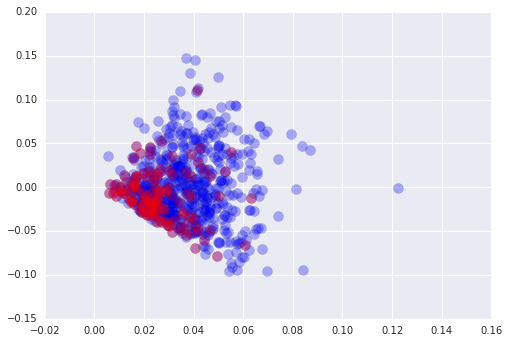

PCAdf shape is 656_10
TCRfeatureDF shape is 656_613
TCRfeatureDF head:
       AA count_0  AA count_1  AA count_T     D01_0
BD406       190.0      8017.0      8207.0  0.381305
BD228       357.0     12365.0     12722.0  0.383422
BD714       208.0     10560.0     10768.0  0.459386
BD808       359.0     19513.0     19872.0  0.508576
number of columns that include nans and their name doesnt include -norm- is 0
these columns will be fillna-ed with 0s
now the number of columns with nan values is 4
building X from its components:
number of Xcomponents to be used is 3
combined X shape is 656_636
656
filtering X rows with sample List = Cardio126
Xshape after filtering rows with sample list = 656_636:
X shape is 656_636
the 100th sample in X is BD124
        Smoking Status_Past  Smoking Status_Yes  Gender_Male
BD1                       1                   0            0
BD10                      1                   0            1
BD1000                    0                   1            1
Y shap

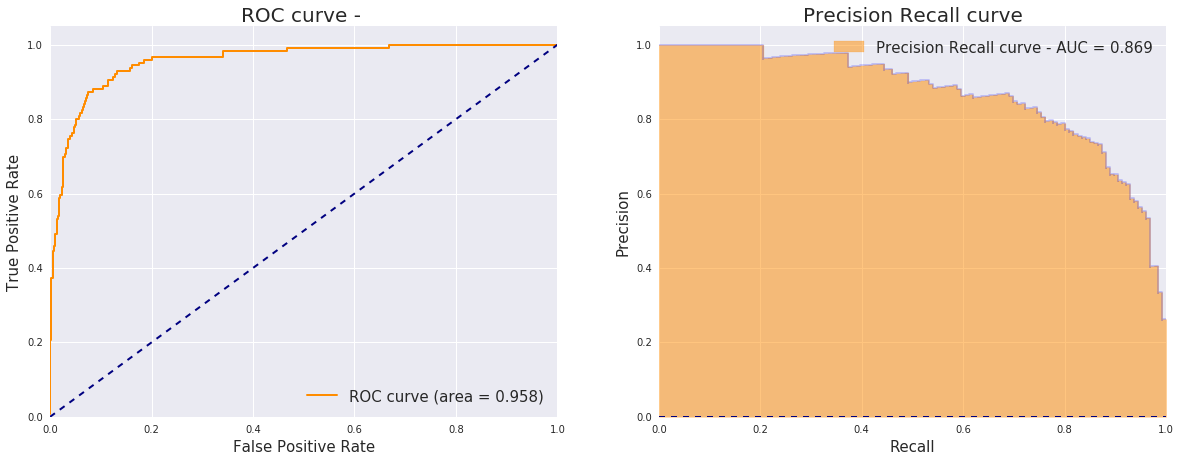

generating summarizing df
126 530
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/Predictions130918/isCardio_predictions/XGBClassifier/predictionDFs/PNP530Cardio126_phenotypes&PCA&TCRfeatures_FSMNone10_scaled_baggingfraction0-5_baggingfreq1_baggingseed3_learningrate0-05_maxdepth6_nestimators100_numthreads2_CV10.xlsx
      Yname                                              Xname      modelName  \
0  isCardio  PNP530Cardio126_phenotypes&PCA&TCRfeatures_FSM...  XGBClassifier   

   roc_auc  pr_auc  perc_pos_target  pr_auc_corrected  useCV  \
0    0.958   0.869            0.192             0.677   True   

   featureSelectionMethod features used    ...     bagging_fraction  \
0                     NaN                  ...                  0.5   

   bagging_freq  bagging_seed  learning_rate  max_depth  n_estimators  \
0           1.0           3.0           0.05        6.0         100.0   

   num_threads   nPos   nNeg     cdate  
0          2.0  126.0  530.0  1

             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
BD1     0.058212 -0.063789 -0.066825  0.125777 -0.076944  0.074758  0.036027   
BD10    0.061757  0.042230 -0.089386 -0.072909 -0.084923  0.004008 -0.014780   
BD1000  0.026693  0.052183  0.027373  0.012638  0.042272 -0.018292  0.009655   
BD1001  0.025615 -0.020438 -0.019540  0.015711  0.002077 -0.000677  0.016378   
BD1002  0.008733  0.004283  0.015124  0.014993 -0.012530  0.000818 -0.002270   

             PC8       PC9      PC10    ...         PC93      PC94      PC95  \
BD1    -0.017756 -0.018324 -0.000549    ...    -0.018748  0.033659  0.059363   
BD10    0.003969 -0.013673  0.030219    ...     0.041279  0.035948  0.015279   
BD1000  0.016931  0.001586  0.024700    ...    -0.042100  0.006226  0.000668   
BD1001  0.010581 -0.002832  0.038932    ...    -0.003868  0.025706  0.044047   
BD1002 -0.013538  0.005867  0.001091    ...    -0.025730  0.006663  0.002700   

            PC96      PC97      PC98  

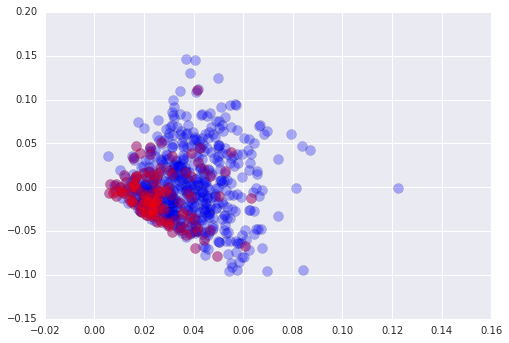

PCAdf shape is 656_100
TCRfeatureDF shape is 656_613
TCRfeatureDF head:
       AA count_0  AA count_1  AA count_T     D01_0
BD406       190.0      8017.0      8207.0  0.381305
BD228       357.0     12365.0     12722.0  0.383422
BD714       208.0     10560.0     10768.0  0.459386
BD808       359.0     19513.0     19872.0  0.508576
number of columns that include nans and their name doesnt include -norm- is 0
these columns will be fillna-ed with 0s
now the number of columns with nan values is 4
building X from its components:
number of Xcomponents to be used is 3
combined X shape is 656_726
656
filtering X rows with sample List = Cardio126
Xshape after filtering rows with sample list = 656_726:
X shape is 656_726
the 100th sample in X is BD124
        Smoking Status_Past  Smoking Status_Yes  Gender_Male
BD1                       1                   0            0
BD10                      1                   0            1
BD1000                    0                   1            1
Y sha

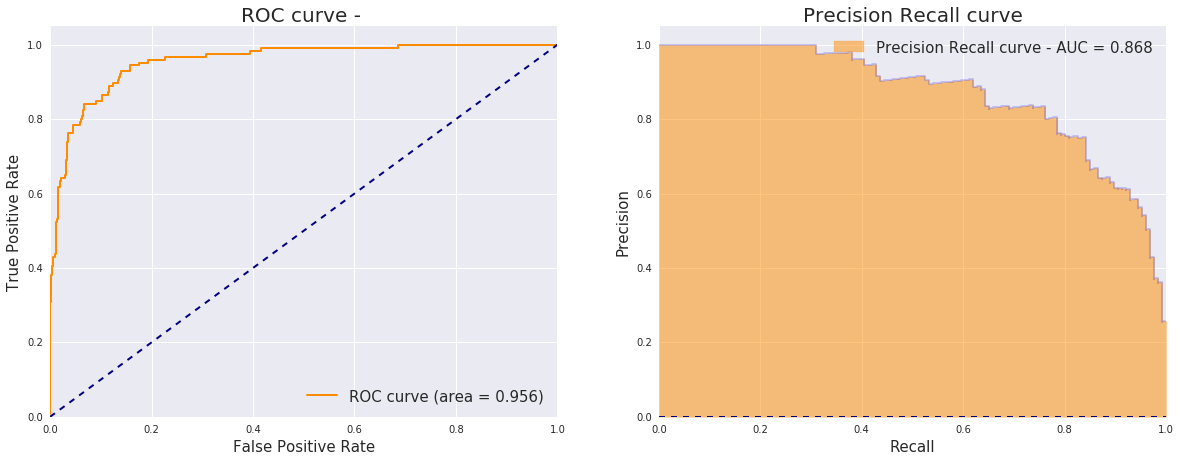

generating summarizing df
126 530
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/Predictions130918/isCardio_predictions/XGBClassifier/predictionDFs/PNP530Cardio126_phenotypes&PCA&TCRfeatures_FSMNone10_scaled_baggingfraction0-5_baggingfreq1_baggingseed3_learningrate0-05_maxdepth6_nestimators100_numthreads2_CV10.xlsx
      Yname                                              Xname      modelName  \
0  isCardio  PNP530Cardio126_phenotypes&PCA&TCRfeatures_FSM...  XGBClassifier   

   roc_auc  pr_auc  perc_pos_target  pr_auc_corrected  useCV  \
0    0.956   0.868            0.192             0.676   True   

   featureSelectionMethod features used    ...     bagging_fraction  \
0                     NaN                  ...                  0.5   

   bagging_freq  bagging_seed  learning_rate  max_depth  n_estimators  \
0           1.0           3.0           0.05        6.0         100.0   

   num_threads   nPos   nNeg     cdate  
0          2.0  126.0  530.0  1

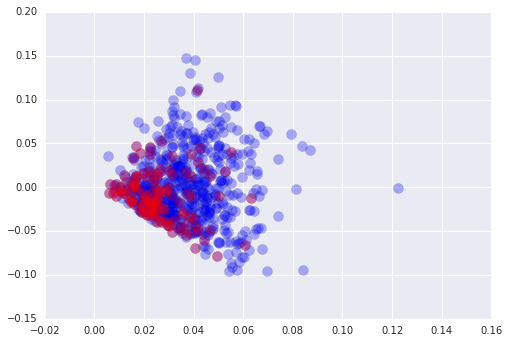

PCAdf shape is 656_10
TCRfeatureDF shape is 656_613
TCRfeatureDF head:
       AA count_0  AA count_1  AA count_T     D01_0
BD406       190.0      8017.0      8207.0  0.381305
BD228       357.0     12365.0     12722.0  0.383422
BD714       208.0     10560.0     10768.0  0.459386
BD808       359.0     19513.0     19872.0  0.508576
number of columns that include nans and their name doesnt include -norm- is 0
these columns will be fillna-ed with 0s
now the number of columns with nan values is 4
building X from its components:
number of Xcomponents to be used is 4
combined X shape is 656_1835
656
since logRef model or univaraite feature selection is used, needs to fillnas in phenotype columns...
X shape after dropping nan columns is 656_1831
Xshape after dropping rows with nans=656_1831
filtering X rows with sample List = Cardio126
Xshape after filtering rows with sample list = 656_1831:
X shape is 656_1831
the 100th sample in X is BD124
        Smoking Status_Past  Smoking Status_Yes  Gend

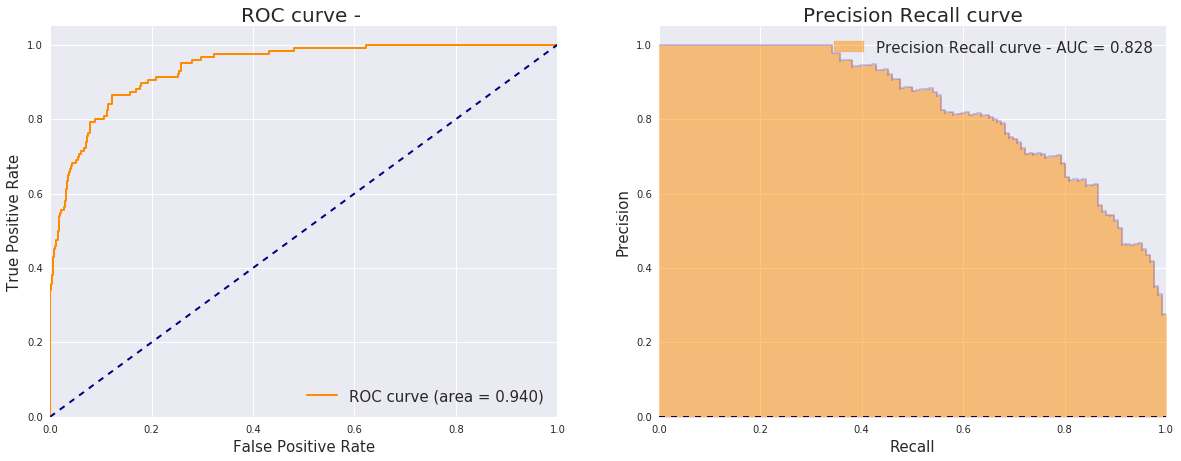

generating summarizing df
126 530
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/Predictions130918/isCardio_predictions/LogisticRegression/predictionDFs/PNP530Cardio126_phenotypes&TCRdf&PCA&TCRfeatures_FSMNone10_scaled_C10_penaltyl1_CV10.xlsx
      Yname                                              Xname  \
0  isCardio  PNP530Cardio126_phenotypes&TCRdf&PCA&TCRfeatur...   

            modelName  roc_auc  pr_auc  perc_pos_target  pr_auc_corrected  \
0  LogisticRegression     0.94   0.828            0.192             0.636   

   useCV  featureSelectionMethod features used  total num features used  \
0   True                     NaN                                    0.0   

   Num features used per split  n_splits     C penalty   nPos   nNeg     cdate  
0                       1831.0      10.0  10.0      l1  126.0  530.0  16092018  
done!!
******featureComposition=phenotypes&TCRdf&PCA&TCRfeatures, k=10,modelAndParams=(<class 'sklearn.linear_model.logistic.Lo

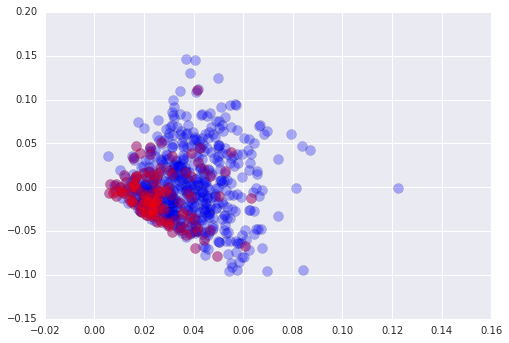

PCAdf shape is 656_100
TCRfeatureDF shape is 656_613
TCRfeatureDF head:
       AA count_0  AA count_1  AA count_T     D01_0
BD406       190.0      8017.0      8207.0  0.381305
BD228       357.0     12365.0     12722.0  0.383422
BD714       208.0     10560.0     10768.0  0.459386
BD808       359.0     19513.0     19872.0  0.508576
number of columns that include nans and their name doesnt include -norm- is 0
these columns will be fillna-ed with 0s
now the number of columns with nan values is 4
building X from its components:
number of Xcomponents to be used is 4
combined X shape is 656_1925
656
since logRef model or univaraite feature selection is used, needs to fillnas in phenotype columns...
X shape after dropping nan columns is 656_1921
Xshape after dropping rows with nans=656_1921
filtering X rows with sample List = Cardio126
Xshape after filtering rows with sample list = 656_1921:
X shape is 656_1921
the 100th sample in X is BD124
        Smoking Status_Past  Smoking Status_Yes  Gen

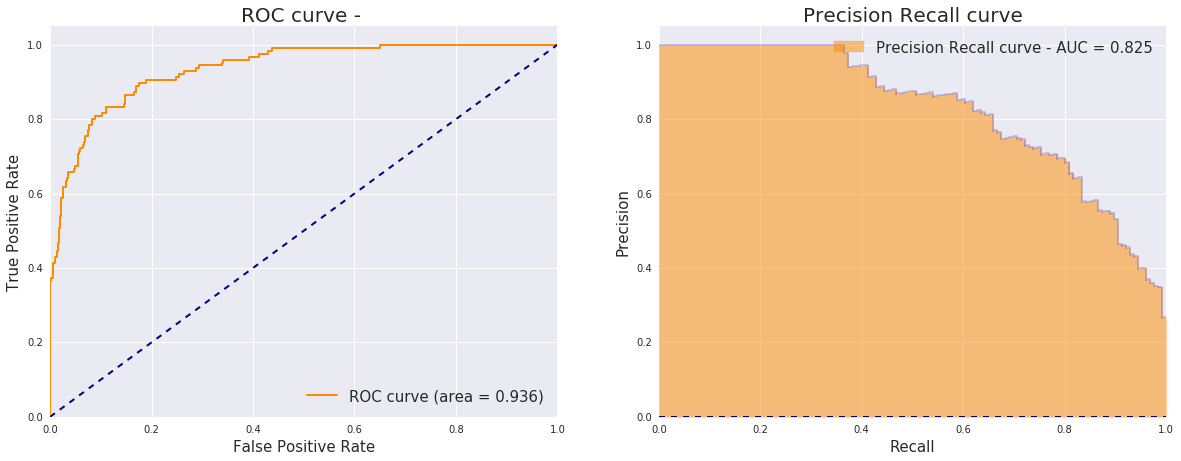

generating summarizing df
126 530
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/Predictions130918/isCardio_predictions/LogisticRegression/predictionDFs/PNP530Cardio126_phenotypes&TCRdf&PCA&TCRfeatures_FSMNone10_scaled_C10_penaltyl1_CV10.xlsx
      Yname                                              Xname  \
0  isCardio  PNP530Cardio126_phenotypes&TCRdf&PCA&TCRfeatur...   

            modelName  roc_auc  pr_auc  perc_pos_target  pr_auc_corrected  \
0  LogisticRegression    0.936   0.825            0.192             0.633   

   useCV  featureSelectionMethod features used  total num features used  \
0   True                     NaN                                    0.0   

   Num features used per split  n_splits     C penalty   nPos   nNeg     cdate  
0                       1921.0      10.0  10.0      l1  126.0  530.0  16092018  
done!!
******featureComposition=phenotypes&TCRdf&PCA&TCRfeatures, k=10,modelAndParams=(<class 'lightgbm.sklearn.LGBMClassifier'

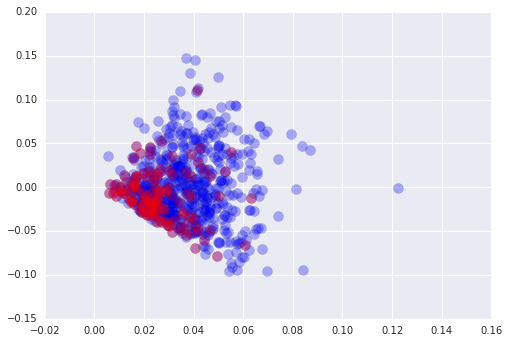

PCAdf shape is 656_10
TCRfeatureDF shape is 656_613
TCRfeatureDF head:
       AA count_0  AA count_1  AA count_T     D01_0
BD406       190.0      8017.0      8207.0  0.381305
BD228       357.0     12365.0     12722.0  0.383422
BD714       208.0     10560.0     10768.0  0.459386
BD808       359.0     19513.0     19872.0  0.508576
number of columns that include nans and their name doesnt include -norm- is 0
these columns will be fillna-ed with 0s
now the number of columns with nan values is 4
building X from its components:
number of Xcomponents to be used is 4
combined X shape is 656_1835
656
filtering X rows with sample List = Cardio126
Xshape after filtering rows with sample list = 656_1835:
X shape is 656_1835
the 100th sample in X is BD124
        Smoking Status_Past  Smoking Status_Yes  Gender_Male
BD1                       1                   0            0
BD10                      1                   0            1
BD1000                    0                   1            1
Y s

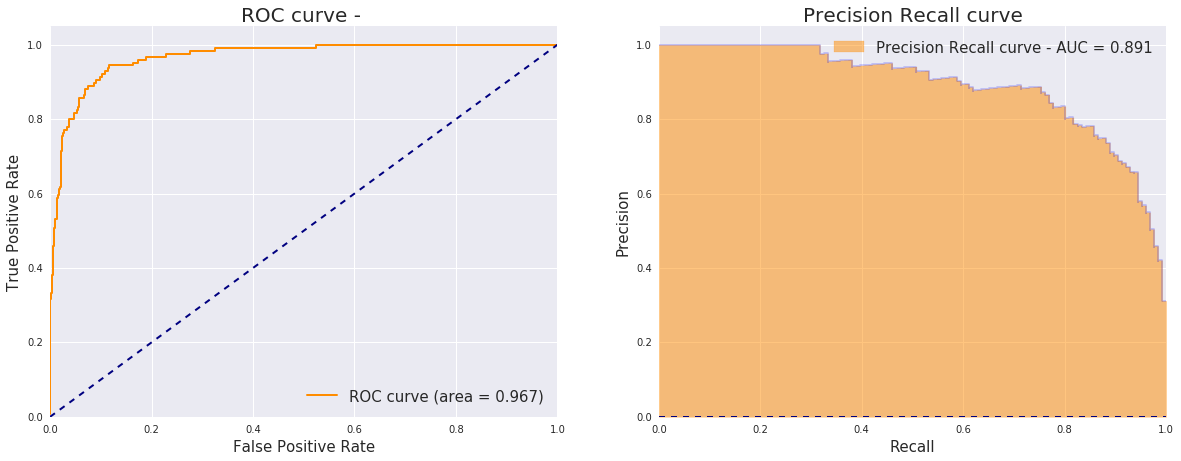

generating summarizing df
126 530
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/Predictions130918/isCardio_predictions/LGBMClassifier/predictionDFs/PNP530Cardio126_phenotypes&TCRdf&PCA&TCRfeatures_FSMNone10_scaled_baggingfraction0-5_baggingfreq1_baggingseed3_learningrate0-05_maxdepth6_nestimators100_numthreads2_CV10.xlsx
      Yname                                              Xname  \
0  isCardio  PNP530Cardio126_phenotypes&TCRdf&PCA&TCRfeatur...   

        modelName  roc_auc  pr_auc  perc_pos_target  pr_auc_corrected  useCV  \
0  LGBMClassifier    0.967   0.891            0.192             0.699   True   

   featureSelectionMethod features used    ...     bagging_fraction  \
0                     NaN                  ...                  0.5   

   bagging_freq  bagging_seed  learning_rate  max_depth  n_estimators  \
0           1.0           3.0           0.05        6.0         100.0   

   num_threads   nPos   nNeg     cdate  
0          2.0  126.0 

             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
BD1     0.058212 -0.063789 -0.066825  0.125777 -0.076944  0.074758  0.036027   
BD10    0.061757  0.042230 -0.089386 -0.072909 -0.084923  0.004008 -0.014780   
BD1000  0.026693  0.052183  0.027373  0.012638  0.042272 -0.018292  0.009655   
BD1001  0.025615 -0.020438 -0.019540  0.015711  0.002077 -0.000677  0.016378   
BD1002  0.008733  0.004283  0.015124  0.014993 -0.012530  0.000818 -0.002270   

             PC8       PC9      PC10    ...         PC93      PC94      PC95  \
BD1    -0.017756 -0.018324 -0.000549    ...    -0.018748  0.033659  0.059363   
BD10    0.003969 -0.013673  0.030219    ...     0.041279  0.035948  0.015279   
BD1000  0.016931  0.001586  0.024700    ...    -0.042100  0.006226  0.000668   
BD1001  0.010581 -0.002832  0.038932    ...    -0.003868  0.025706  0.044047   
BD1002 -0.013538  0.005867  0.001091    ...    -0.025730  0.006663  0.002700   

            PC96      PC97      PC98  

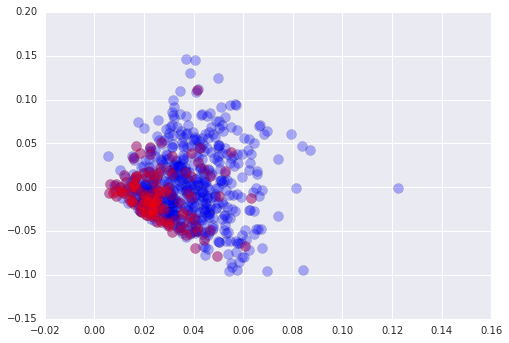

PCAdf shape is 656_100
TCRfeatureDF shape is 656_613
TCRfeatureDF head:
       AA count_0  AA count_1  AA count_T     D01_0
BD406       190.0      8017.0      8207.0  0.381305
BD228       357.0     12365.0     12722.0  0.383422
BD714       208.0     10560.0     10768.0  0.459386
BD808       359.0     19513.0     19872.0  0.508576
number of columns that include nans and their name doesnt include -norm- is 0
these columns will be fillna-ed with 0s
now the number of columns with nan values is 4
building X from its components:
number of Xcomponents to be used is 4
combined X shape is 656_1925
656
filtering X rows with sample List = Cardio126
Xshape after filtering rows with sample list = 656_1925:
X shape is 656_1925
the 100th sample in X is BD124
        Smoking Status_Past  Smoking Status_Yes  Gender_Male
BD1                       1                   0            0
BD10                      1                   0            1
BD1000                    0                   1            1
Y 

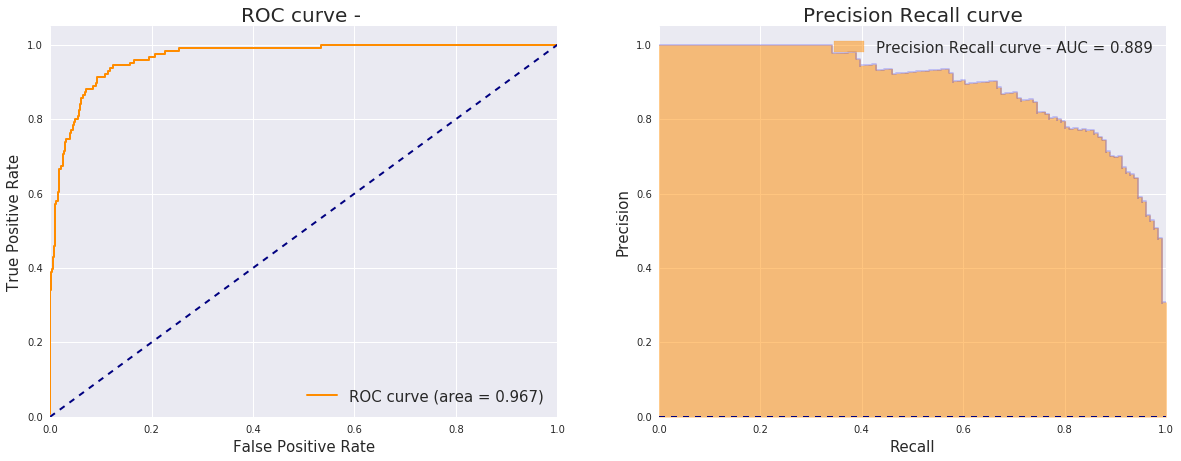

generating summarizing df
126 530
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/Predictions130918/isCardio_predictions/LGBMClassifier/predictionDFs/PNP530Cardio126_phenotypes&TCRdf&PCA&TCRfeatures_FSMNone10_scaled_baggingfraction0-5_baggingfreq1_baggingseed3_learningrate0-05_maxdepth6_nestimators100_numthreads2_CV10.xlsx
      Yname                                              Xname  \
0  isCardio  PNP530Cardio126_phenotypes&TCRdf&PCA&TCRfeatur...   

        modelName  roc_auc  pr_auc  perc_pos_target  pr_auc_corrected  useCV  \
0  LGBMClassifier    0.967   0.889            0.192             0.697   True   

   featureSelectionMethod features used    ...     bagging_fraction  \
0                     NaN                  ...                  0.5   

   bagging_freq  bagging_seed  learning_rate  max_depth  n_estimators  \
0           1.0           3.0           0.05        6.0         100.0   

   num_threads   nPos   nNeg     cdate  
0          2.0  126.0 

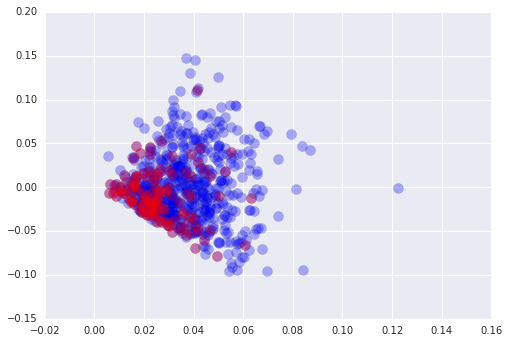

PCAdf shape is 656_10
TCRfeatureDF shape is 656_613
TCRfeatureDF head:
       AA count_0  AA count_1  AA count_T     D01_0
BD406       190.0      8017.0      8207.0  0.381305
BD228       357.0     12365.0     12722.0  0.383422
BD714       208.0     10560.0     10768.0  0.459386
BD808       359.0     19513.0     19872.0  0.508576
number of columns that include nans and their name doesnt include -norm- is 0
these columns will be fillna-ed with 0s
now the number of columns with nan values is 4
building X from its components:
number of Xcomponents to be used is 4
combined X shape is 656_1835
656
filtering X rows with sample List = Cardio126
Xshape after filtering rows with sample list = 656_1835:
X shape is 656_1835
the 100th sample in X is BD124
        Smoking Status_Past  Smoking Status_Yes  Gender_Male
BD1                       1                   0            0
BD10                      1                   0            1
BD1000                    0                   1            1
Y s

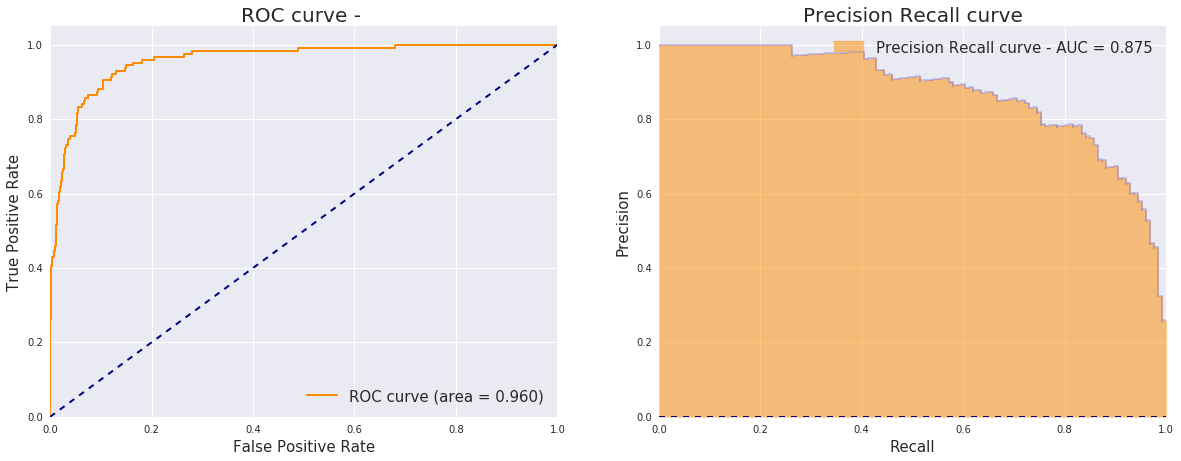

generating summarizing df
126 530
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/Predictions130918/isCardio_predictions/XGBClassifier/predictionDFs/PNP530Cardio126_phenotypes&TCRdf&PCA&TCRfeatures_FSMNone10_scaled_baggingfraction0-5_baggingfreq1_baggingseed3_learningrate0-05_maxdepth6_nestimators100_numthreads2_CV10.xlsx
      Yname                                              Xname      modelName  \
0  isCardio  PNP530Cardio126_phenotypes&TCRdf&PCA&TCRfeatur...  XGBClassifier   

   roc_auc  pr_auc  perc_pos_target  pr_auc_corrected  useCV  \
0     0.96   0.875            0.192             0.683   True   

   featureSelectionMethod features used    ...     bagging_fraction  \
0                     NaN                  ...                  0.5   

   bagging_freq  bagging_seed  learning_rate  max_depth  n_estimators  \
0           1.0           3.0           0.05        6.0         100.0   

   num_threads   nPos   nNeg     cdate  
0          2.0  126.0  53

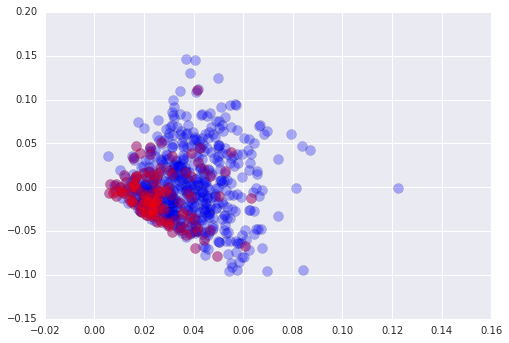

PCAdf shape is 656_100
TCRfeatureDF shape is 656_613
TCRfeatureDF head:
       AA count_0  AA count_1  AA count_T     D01_0
BD406       190.0      8017.0      8207.0  0.381305
BD228       357.0     12365.0     12722.0  0.383422
BD714       208.0     10560.0     10768.0  0.459386
BD808       359.0     19513.0     19872.0  0.508576
number of columns that include nans and their name doesnt include -norm- is 0
these columns will be fillna-ed with 0s
now the number of columns with nan values is 4
building X from its components:
number of Xcomponents to be used is 4
combined X shape is 656_1925
656
filtering X rows with sample List = Cardio126
Xshape after filtering rows with sample list = 656_1925:
X shape is 656_1925
the 100th sample in X is BD124
        Smoking Status_Past  Smoking Status_Yes  Gender_Male
BD1                       1                   0            0
BD10                      1                   0            1
BD1000                    0                   1            1
Y 

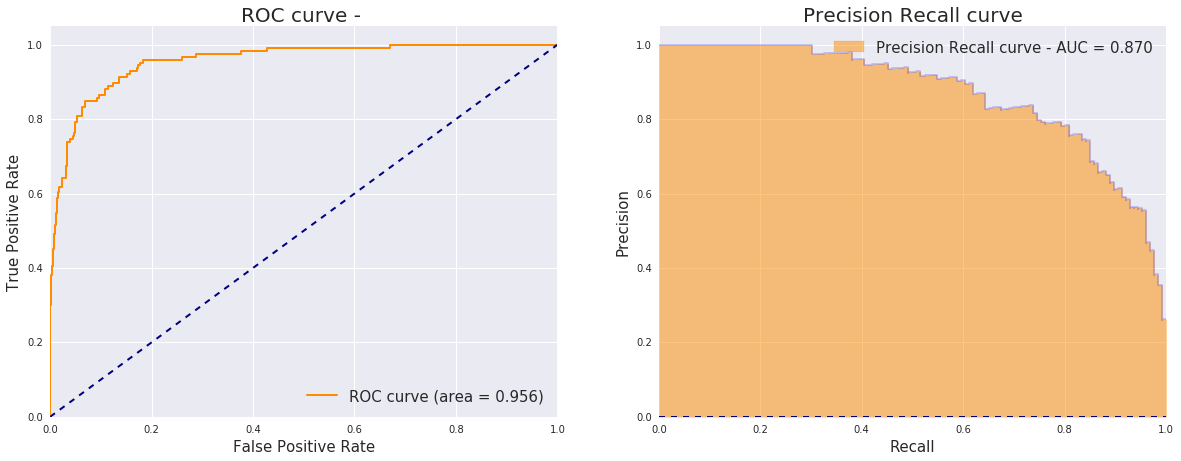

generating summarizing df
126 530
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/Predictions130918/isCardio_predictions/XGBClassifier/predictionDFs/PNP530Cardio126_phenotypes&TCRdf&PCA&TCRfeatures_FSMNone10_scaled_baggingfraction0-5_baggingfreq1_baggingseed3_learningrate0-05_maxdepth6_nestimators100_numthreads2_CV10.xlsx
      Yname                                              Xname      modelName  \
0  isCardio  PNP530Cardio126_phenotypes&TCRdf&PCA&TCRfeatur...  XGBClassifier   

   roc_auc  pr_auc  perc_pos_target  pr_auc_corrected  useCV  \
0    0.956    0.87            0.192             0.678   True   

   featureSelectionMethod features used    ...     bagging_fraction  \
0                     NaN                  ...                  0.5   

   bagging_freq  bagging_seed  learning_rate  max_depth  n_estimators  \
0           1.0           3.0           0.05        6.0         100.0   

   num_threads   nPos   nNeg     cdate  
0          2.0  126.0  53

In [6]:
datasetName='PNP530Cardio126'

featureComposition_list=['phenotypesOnly','phenotypes&PCA&TCRfeatures','phenotypes&TCRdf&PCA&TCRfeatures']
# featureComposition_list=['phenotypesOnly']
for featureComposition in featureComposition_list:
    
    modelAndParams_list=[(LogisticRegression,'LogisticRegression',{'C':10,'penalty':'l1'}),
               (lgb.LGBMClassifier,'LGBMClassifier',{'learning_rate': 0.05, 'n_estimators': 100,'max_depth': 6,'num_threads':2,
         'bagging_fraction':0.5,'bagging_freq':1, 'bagging_seed':3}),
               (XGBClassifier,'XGBClassifier',{'learning_rate': 0.05, 'n_estimators': 100,'max_depth': 6,'num_threads':2,
         'bagging_fraction':0.5,'bagging_freq':1, 'bagging_seed':3})]

    for modelAndParams in modelAndParams_list:
        model=modelAndParams[0]
        modelName=modelAndParams[1]
        model_params=modelAndParams[2] 

        if model==LogisticRegression:
#             featureSelectionMethod_list=[f_classif,'random',None]
            featureSelectionMethod_list=[None]
        else:
            featureSelectionMethod_list=[None]
#             featureSelectionMethod_list=[f_classif,'random','usingModel',None]
        if featureComposition=='phenotypesOnly':
            featureSelectionMethod_list=[None]
        for featureSelectionMethod in featureSelectionMethod_list:

            if (featureComposition=='phenotypesOnly') | (featureSelectionMethod==None):
                kList=[10]
            else:
                kList=[10,100,200]    
            for k in kList:

                XName='%s_%s' %(datasetName,featureComposition)
                if featureComposition=='phenotypesOnly':
                    useTCRfeatures=False #True/False
                    usePCAdf=False #True/False
                    useTCRdf=False #True/False   
                elif featureComposition=='phenotypes&PCA&TCRfeatures':
                    useTCRfeatures=True #True/False
                    usePCAdf=True #True/False
                    useTCRdf=False #True/False
                elif featureComposition=='phenotypes&TCRdf&PCA&TCRfeatures':
                    useTCRfeatures=True #True/False
                    usePCAdf=True #True/False
                    useTCRdf=True #True/False

                n_comp_list=[10,100]
                for n_comp in n_comp_list: 
                    print '******featureComposition=%s, k=%s,modelAndParams=%s,featureSelectionMethod=%s,n_comp=%s********'\
    %(featureComposition,k,modelAndParams,featureSelectionMethod,n_comp)

                    # (1) general definitions:
                    datasetType='PNP_Cardio' #PNP/PNP_Cardio

                    #(2) model definitions:
                    ResultFolder='%s/TCR_real_data/CardioSamples/Predictions130918' %MyPath
                    if not isdir(ResultFolder):
                        makedirs(ResultFolder)

                    n_splits=10
                    useCV=True
                    stratifiedCV=True

                    # (5) phenotypeDF:

                    genPhenotypeDF=False #True/False. no sense for 'True'  if usePhenotype=False
                    phenotypeDF=combinedPhenotypeDF
                    phenotypeDFname='septFeatures' #('small','allNum and more- see step #6.2

                    #(3) target definition:
                    targetDF=pd.DataFrame(index=['BD'+str(x) for x in range(1,1100)])
                    targetDF['isCardio']=np.where(targetDF.index.str.replace('BD','').astype(int)>949,1,0)
                    targetName='isCardio'
                    YName=targetName
                    print 'target value counts:'
                    print targetDF[targetName].value_counts(dropna=False)

                    #  (4) feature composition:
                    usePhenotype=True #True/False

                    # (6) TCRdf:
                    datasetFolder='%s/TCR_real_data/CardioSamples' %MyPath
                    datasetNameTCRdf=datasetName  
                    TCRdfName='sharingMatrix_Cardio126_minNshared2_RA_onlyProductiveTrue__percShared10_OLtrimmed_binary'
                    TCRdf=TCRdf

                    #(7) PCAdf (based on the TCRdf selected)
    #                 n_comp=100 # int or None 
                    isSparse=True #True/False

                    #(8) TCRfeatures:
                    getTCRfeatures=False #True/False. do not use True when useTCRfeatures=False
                    TCRfeatureDF=TCRfeatureDF2

                    sampleList=sampleList
                    sampleListName='Cardio126'

                    filterFeaturesByCorr=None #None or float between 0 and 1
                    featureSelectionUsingModel=False # True/False
            #                     C=0.5 #None (if none, C will be set to 0.1) or float between 0 and 1
            #                     filterFeaturesByUnivariate=f_classif    # None/chi2/f_classif/mutual_info_classif
            #             k=150 #None (will be set to 50 / int - defines number of k best))
                    scale=True

                    predictionPipeline(datasetType,ResultFolder,model,modelName,model_params,n_splits, useCV,
                                          stratifiedCV, XName,usePhenotype,useTCRdf,useTCRfeatures,usePCAdf,
                                          YName,targetDF,
                                          genPhenotypeDF,phenotypeDF,phenotypeDFname,
                                          datasetFolder,datasetNameTCRdf,TCRdf,TCRdfName,n_comp,isSparse,
                                          getTCRfeatures,TCRfeatureDF,sampleListName,sampleList,
                                          filterFeaturesByCorr,featureSelectionMethod,scale,
                                          k,cdate=cdate,overwriteResults=True)


print 'done with all iterations...'

## explore results:

In [7]:
modelNameList=['LogisticRegression','LGBMClassifier','XGBClassifier']
YName='isCardio'

for modelName in modelNameList:
    print modelName
    folder='%s/TCR_real_data/CardioSamples/Predictions130918/%s_predictions/%s' %(MyPath,YName,modelName)
    df_folder='%s/predictionDFs' %folder
    print folder
    results=concat_summarizing_dfs_excel(df_folder)
    results=results.sort_values(by='roc_auc', ascending=False)
    f1='%s/resultSummary_%s.xlsx' %(folder,cdate)
    results.to_excel(f1)
    results.head(20)
    

LogisticRegression
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/Predictions130918/isCardio_predictions/LogisticRegression
number of dfs in directory: 15
the length of df list is 15
LGBMClassifier
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/Predictions130918/isCardio_predictions/LGBMClassifier
number of dfs in directory: 21
the length of df list is 21
XGBClassifier
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/Predictions130918/isCardio_predictions/XGBClassifier
number of dfs in directory: 21
the length of df list is 21
